In [1]:
import jax.numpy as np
import numpy as onp
from jax import random, grad, jit, vmap
from functools import partial
key = random.PRNGKey(0)
from jax.experimental import optimizers
from NODE_ICNN_CANN_MF_fns import *
import matplotlib.pyplot as plt
import pickle
from jax.config import config
import pandas as pd
config.update("jax_enable_x64", True)
plt.rcParams.update({'font.size': 12})

import pandas as pd
from sklearn.metrics import r2_score

/opt/homebrew/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/opt/homebrew/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


# 2nd derivatives of SEDF

In [2]:
class CANN_model():
    def __init__(self, params_I1, params_I2,normalization):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        self.normalization = normalization
    # Psi1
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        return CANN_dpsidInorm(I1norm,self.params_I1)[:,0]/self.normalization[0]
    # Psi2
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        return CANN_dpsidInorm(I2norm,self.params_I2)[:,0]/self.normalization[1]

# play with ICNN a bit, how do we get that one to work
class ICNN_model():
    def __init__(self, params_I1, params_I2,normalization):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        self.normalization = normalization
    # Psi1
    # note: for ICNN the prediction is the function not the gradient
    # but the P11_UT, P11_ET, etc expects the model to output the derivative
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        f1 = lambda x: icnn_forwardpass(x, self.params_I1)[0]
        #normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
        df1 = grad(f1)
        return vmap(df1)(I1norm[:,None])[:,0]/self.normalization[0]
    # Psi2
    # note: for ICNN the prediction is the function not the gradient
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        f2 = lambda x: icnn_forwardpass(x, self.params_I2)[0]
        #normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]
        df2 = grad(f2)
        return vmap(df2)(I2norm[:,None])[:,0]/self.normalization[1]
        
## NODE model outputs normalized strain energy given normalized invariants
class NODE_model():
    def __init__(self, params_I1, params_I2, normalization):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        return NODE_posb_vmap(I1norm, self.params_I1)
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        return NODE_posb_vmap(I2norm, self.params_I2)

def plotstresses(x_gt,y_gt,x_pr,y_pr):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    labels = ['UT', 'ET', 'PS']
    for axi, x_gti, y_gti, x_pri, y_pri, label in zip(ax, x_gt, y_gt, x_pr, y_pr, labels):
        axi.plot(x_gti, y_gti, 'k.')
        axi.plot(x_pri, y_pri)
        axi.set_title(label)
        axi.set_xlabel(r'Stretch $\lambda [-]$')
        axi.set_ylabel(r'Nominal stress $P_{11} [MPa]$')
    return fig, ax

In [3]:
## Eval invariants for the three types of deformation
def evalI1_UT(lam):
    return lam**2 + (2/lam)
def evalI2_UT(lam):
    return 2*lam + (1/lam**2)

def evalI1_ET(lam):
    return 2*lam**2 +1/lam**4
def evalI2_ET(lam):
    return lam**4 + 2/lam**2

def evalI1_PS(lam):
    return lam**2 + 1/lam**2 + 1
def evalI2_PS(lam):
    return lam**2 + 1/lam**2 + 1

In [4]:
def Psi1(I1, model, norm):
    I1_factor = norm[0]
    Psi1_factor = norm[2]
    I1 = (I1-3)/I1_factor
    Psi1 = model.Psi1norm(I1)*Psi1_factor
    return Psi1[0] #[0] is a quick way of reverting vectorization
Psi11 = grad(Psi1)

def Psi2(I2, model, norm):
    I2_factor = norm[1]
    Psi2_factor = norm[3]
    I2 = (I2-3)/I2_factor
    Psi2 = model.Psi2norm(I2)*Psi2_factor
    return Psi2[0]
Psi22 = grad(Psi2)

In [5]:
# Normalization constants
I1_factor = 30
Psi1_factor = 0.3
I2_factor = 250
Psi2_factor = 0.001
normalization = [I1_factor,I2_factor,Psi1_factor,Psi2_factor ]

CANN UT
0.0 0.0009709814689256485
ICNN UT
1.1718189538964317e-05 0.0450718748398273
NODE UT
0.0014808527747094899 4.00028335001924e-06
CANN ET
1.734069773783345e-22 7.583875800011521e-06
ICNN ET
3.4091114631377562e-06 8.352846997865834e-11
NODE ET
0.00021819214024833497 -6.1203547220444615e-34
CANN PS
8.513135641149773e-26 2.069963088601833e-12
ICNN PS
8.830106211914309e-11 2.57139193241836e-09
NODE PS
-1.084554143592745e-10 4.4875352143342424e-06
CANN all
8.057302625523807e-15 5.928519984516912e-18
ICNN all
9.282151351448039e-06 1.5523497767117147e-10
NODE all
5.404682391995448e-05 9.449213751528485e-11


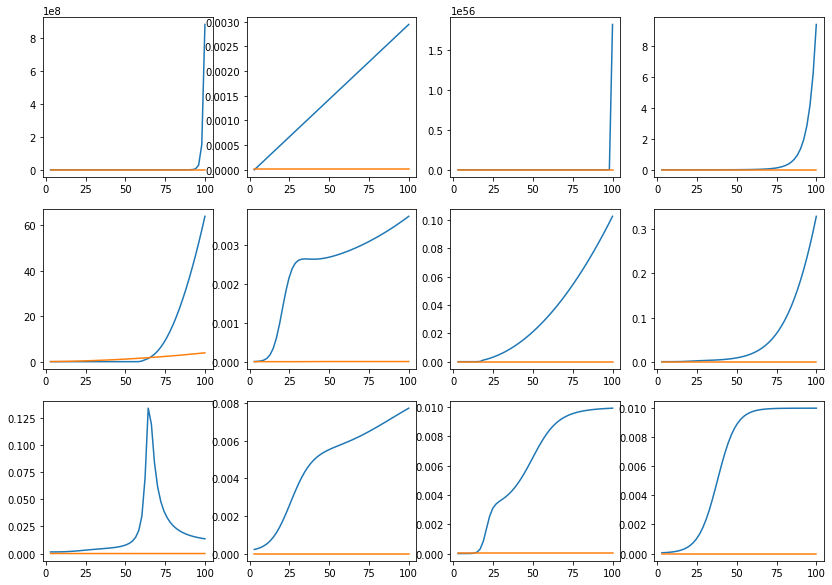

In [6]:
fig, axes = plt.subplots(3,4,figsize=(14,10))
train_cases = ['UT', 'ET', 'PS', 'all']
panels_list = [['a','e','i'],['b','f','j'],['c','g','k'],['d','h','l']]
for ax, train_case, panels in zip(axes.T, train_cases, panels_list):
    models      = [CANN_model, ICNN_model, NODE_model]
    model_names = ['CANN',     'ICNN',     'NODE']
    for axi, MODEL, model_name, panel in zip(ax, models, model_names, panels):
        with open('savednet/'+model_name+'_params_'+train_case+'.npy', 'rb') as f:
            params = pickle.load(f)
        model = MODEL(params[0], params[1], normalization)
        
        Ii = np.linspace(3,100)
        Psi_11 = []
        Psi_22 = []
        for i in range(Ii.shape[0]):
            I = np.expand_dims(Ii[i],axis=0)
            Psi_11.append(Psi11(I, model, normalization))
            Psi_22.append(Psi22(I, model, normalization))
        axi.plot(Ii, Psi_11)
        axi.plot(Ii, Psi_22)
        print(model_name, train_case)
        print(np.min(np.array(Psi_11)), np.min(np.array(Psi_22)))

        Psi_11 = np.array(Psi_11).squeeze()
        Psi_22 = np.array(Psi_22).squeeze()

        Psi_11 = np.clip(Psi_11, a_min = 0, a_max = 100)
        Psi_22 = np.clip(Psi_22, a_min = 0, a_max = 100)

        data = np.array([Ii, Psi_11, Psi_22])
        columns = ['x','Psi11', 'Psi22']
        df = pd.DataFrame(data.T, columns=columns)
        df.to_csv('TikZ/fig_rubberd2_data/'+panel+'.csv', index=False, sep = ' ')

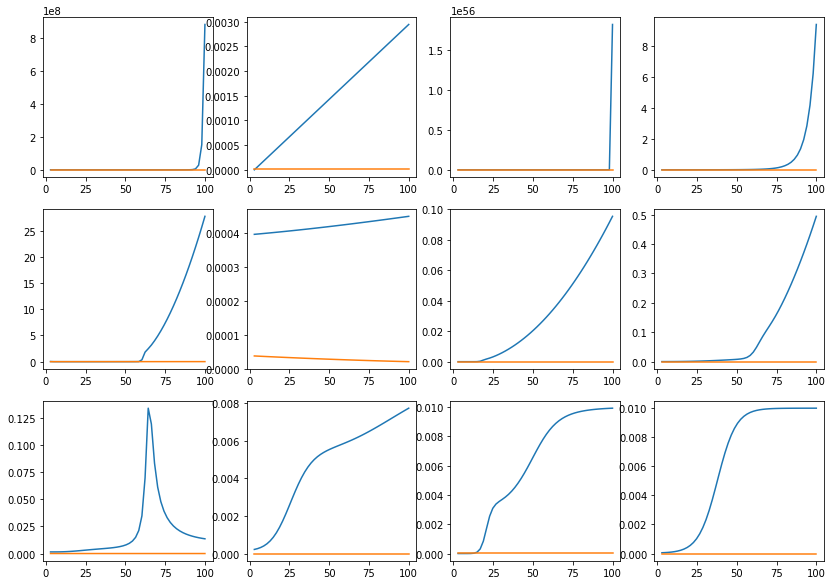

In [15]:
fig, axes = plt.subplots(3,4,figsize=(14,10))
train_cases = ['UT', 'ET', 'PS', 'all']
panels_list = [['a','e','i'],['b','f','j'],['c','g','k'],['d','h','l']]
for ax, train_case, panels in zip(axes.T, train_cases, panels_list):
    models      = [CANN_model, ICNN_model, NODE_model]
    model_names = ['CANN',     'ICNN',     'NODE']
    for axi, MODEL, model_name, panel in zip(ax, models, model_names, panels):
        with open('savednet/'+model_name+'_params_'+train_case+'.npy', 'rb') as f:
            params = pickle.load(f)
        model = MODEL(params[0], params[1], normalization)
        
        Ii = np.linspace(3,100)
        Psi_11 = []
        Psi_22 = []
        for i in range(Ii.shape[0]):
            I = np.expand_dims(Ii[i],axis=0)
            Psi_11.append(Psi11(I, model, normalization))
            Psi_22.append(Psi22(I, model, normalization))
        axi.plot(Ii, Psi_11)
        axi.plot(Ii, Psi_22)

        Psi_11 = np.array(Psi_11).squeeze()
        Psi_22 = np.array(Psi_22).squeeze()

        Psi_11 = np.clip(Psi_11, a_min = 0, a_max = 100)
        Psi_22 = np.clip(Psi_22, a_min = 0, a_max = 100)

        data = np.array([Ii, Psi_11, Psi_22])
        columns = ['x','Psi11', 'Psi22']
        df = pd.DataFrame(data.T, columns=columns)
        df.to_csv('TikZ/fig_rubberd2_data/'+panel+'.csv', index=False, sep = ' ')